In [20]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')

In [21]:
# Paths
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_2'
samples_dir = os.path.join(base_dir, 'samples')
sample_cluster_dir = os.path.join(base_dir, 'sample_clustering')
figure_dir = os.path.join(base_dir, 'figures')
train_align_dir = os.path.join(base_dir, 'train_align')
train_pdbs_dir = os.path.join(base_dir, 'training_pdbs')


base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_align_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(train_pdbs_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(sample_cluster_dir, exist_ok=True)



if len(os.listdir(base_dir)):
    print('WARNING: overwriting results!')

# Read unconditional sampling results

In [22]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/refold'
print(f'Reading samples from {results_dir}')
for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    # for i,sample_name in enumerate(os.listdir(length_dir)):
    #     if '.' in sample_name:
    #         continue
    csv_path = os.path.join(length_dir, 'sc_results.csv')
    if os.path.exists(csv_path):
        design_csv = pd.read_csv(csv_path, index_col=0)
        design_csv['length'] = int(sample_length.split('_')[1])
        design_csv['sample_id'] = int(sample_length.split('_')[2])
        all_csvs.append(design_csv)
results_df = pd.concat(all_csvs)

Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/refold


In [23]:
# Process sample path
def pick_path(x):
    if x.sample_path is None or x.sample_path == '':
        return x.of_path
    return x.sample_path
results_df['sample_path'] = results_df['sample_path'].fillna('')
results_df['sample_path'] = results_df.apply(pick_path, axis=1)

In [24]:
# Separate based on whether MPNNed
results_df['header'] = results_df['header'].fillna('')
results_df['Post-ProteinMPNN'] = results_df['header'].map(lambda x: 'sde_1' not in x)

# Whether to only use MPNNed designs or not
results_df = results_df[results_df['Post-ProteinMPNN']]

In [25]:
# Gather top TM-score for each length and sample in each length
hallucination_sc_df = results_df.sort_values('rmsd', ascending=True)
hallucination_sc_df = hallucination_sc_df.groupby(['length', 'sample_id', 'Post-ProteinMPNN']).first().reset_index()
# hallucination_sc_df = hallucination_sc_df[hallucination_sc_df.length >= 100]

In [26]:
# Separate into different length groups
length_categories = [
    '60-100', '60-200', '200-300', '300-400', '400-500'
][::-1]
buckets = np.arange(0, 501, 100)
hallucination_sc_df['length_group'] = hallucination_sc_df.length.map(lambda x: length_categories[np.sum(x < buckets).item()-1])
hallucination_sc_df['length_group'] = pd.Categorical(hallucination_sc_df['length_group'], ordered=True, categories=length_categories[::-1])

In [27]:
# Calculate how designable
cutoff = 0.5
hallucination_sc_df['designable'] = hallucination_sc_df.tm_score.map(lambda x: x > cutoff)
designable_df = pd.pivot_table(hallucination_sc_df, values='designable', index='length_group', aggfunc=np.mean).reset_index()
percent_design = hallucination_sc_df['designable'].mean()
print(f'Percent designable: {percent_design}')

Percent designable: 0.650561797752809


# Plot TM-score and success rate across length groups

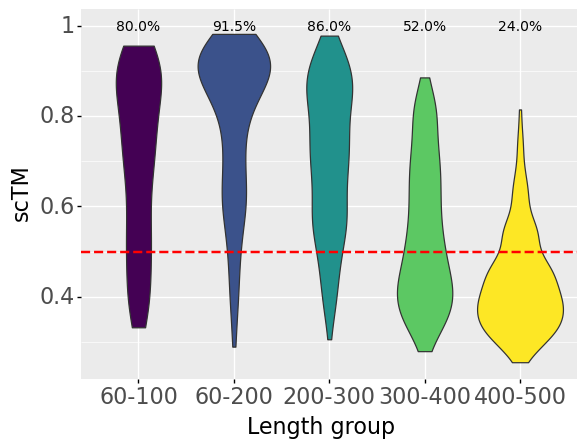

In [9]:
# Plot
p = (
    gg.ggplot(
        hallucination_sc_df,
        gg.aes('length_group', 'tm_score', fill='length_group')
    )
    + gg.geom_violin(
        show_legend=False
    )
    # + gg.facet_wrap('mpnn')
    + gg.geoms.geom_hline(
        yintercept=cutoff,
        size=1.0,
        linetype='dashed',
        color='red',
    )
    + gg.labels.ylab('scTM')
    + gg.labels.xlab('Length group')
    # + gg.labels.ggtitle('Unconditional generation')
    + gg.theme(text=gg.element_text(size=16))
)

for _, row in designable_df.iterrows():
    p += gg.annotate(
        "text",
        label = f"{row.designable*100:2.1f}%",
        x=row.length_group,
        y = 1.0,
        size = 10,
        colour = "black"
    )

print(p)

In [ ]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'unconditional_sctm.png')
p.save(filename=fig_path, dpi=300)

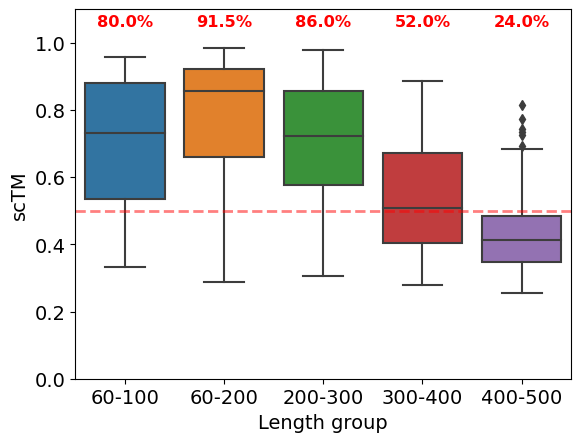

In [28]:
plt.rcParams.update({'font.size': 14})
p = sns.boxplot(
    data=hallucination_sc_df,
    x='length_group',
    y='tm_score',
)

designable_numbers = designable_df.designable.tolist()
for i,xtick in enumerate(p.get_xticks()):
    p.text(
        xtick,
        1.05,
        f"{designable_numbers[i]*100:2.1f}%",
        horizontalalignment='center',
        size='small',
        color='red',
        weight='semibold'
    )
plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
plt.ylim(0.0, 1.1)
plt.xlabel('Length group')
plt.ylabel('scTM')
plt.show()
# fig_path = os.path.join(figure_dir, 'unconditional_sctm_plt.png')
# plt.savefig(fig_path, dpi=300)

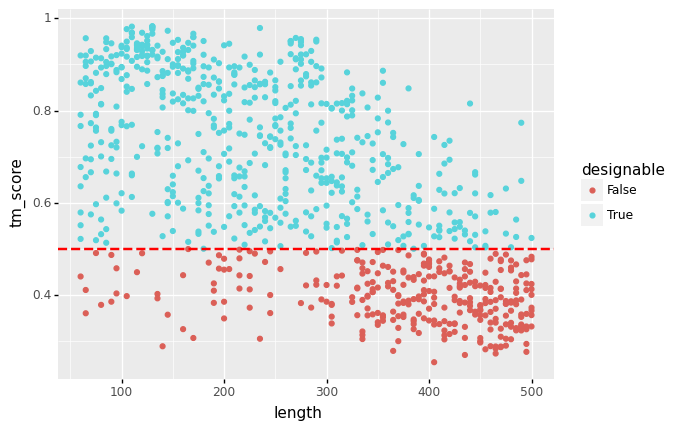

In [19]:
p = (
    gg.ggplot(
        hallucination_sc_df,
        gg.aes('length', 'tm_score', fill='designable', color='designable')
    )
    + gg.geom_point(
        # show_legend=False
    )
    # + gg.facet_wrap('mpnn')
    + gg.geoms.geom_hline(
        yintercept=cutoff,
        size=1.0,
        linetype='dashed',
        color='red',
    )
    # + gg.labels.ylab('scTM')
    # + gg.labels.xlab('Length group')
    # + gg.labels.ggtitle('Unconditional generation')
    # + gg.theme(text=gg.element_text(size=16))
)
print(p)

In [ ]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'unconditional_sctm_scatter.png')
p.save(filename=fig_path, dpi=300)

In [ ]:
# Plot
p = (
    gg.ggplot(
        hallucination_sc_df,
        gg.aes('tm_score', color='length_group')
    )
    + gg.stats.stat_ecdf()
    + gg.scales.scale_x_reverse()
    + gg.geoms.geom_vline(
        xintercept=cutoff,
        size=1.0,
        linetype='dashed',
        color='red',
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Percentage of designs')
)

print(p)

In [100]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'cumulative_sctm.png')
p.save(filename=fig_path, dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_2/figures/cumulative_sctm.png


In [104]:
# Save all designable hallucination samples
designable_samples_df = hallucination_sc_df[hallucination_sc_df.designable]
# if os.path.isdir(all_samples_path):
#     shutil.rmtree(samples_path)
# os.makedirs(samples_path, exist_ok=True)
fname = os.path.join(samples_dir, 'sc_pdbs.txt')
with open(fname, 'w') as f:
    for _, row in designable_samples_df.iterrows():
        sample_path = row.sample_path
        full_path = os.path.join(base_protdiff_dir, sample_path)
        if 'hallucination/0' not in sample_path:
            full_path = full_path.replace('hallucination', 'hallucination/0')
        file_name = f'length_{str(row.length)}_id_{str(row.sample_id)}.pdb'
        save_path = os.path.join(samples_dir, file_name)
        shutil.copy(full_path, save_path)
        f.write(save_path+'\n')

# Clustering analysis

In [9]:
file = os.path.join(sample_cluster_dir, 'all_by_all_lite')
with open(file, 'r') as f:
    text = f.read()
    
    size = re.findall(r'SIZE :(.*\d+)', text)[0]
    size = int(size)
    
    id_to_filename = {}
    D = np.ones((size,size))
    for line in text.splitlines():
        if line[:3] == 'PDB':
            _, id_, filename = line.split()
            id_ = int(id_)
            id_to_filename[id_] = filename
        elif line[:2] == 'MS':
            _, _, idx1, idx2, tm1, tm2, pairs = line.split()
            i, j = int(idx1)-1, int(idx2)-1
            tm1, tm2 = float(tm1), float(tm2)
            tm_mean = (tm1 + tm2) / 2
            D[i, j] = 1 - tm1
            D[j, i] = 1 - tm2
D_mean = (D + D.T) / 2
    

In [ ]:
plt.figure(figsize=(2,2))
g = sns.clustermap(
    1 - D_mean,
    method='average',
    figsize=(10,10),
    yticklabels=False,
    xticklabels=False,
    cbar_pos=(0.1, 0.02, 0.05, 0.75),
    cmap='viridis'
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# plt.show()
plt.savefig(os.path.join(figure_dir, 'unconditional_sample_clustering.png'))

# Align samples to training PDBs

### Save traiing PDBs

In [ ]:
def int_to_chain(i,base=62):
    """
    int_to_chain(int,int) -> str
    Converts a positive integer to a chain ID. Chain IDs include uppercase
    characters, numbers, and optionally lowercase letters.
    i = a positive integer to convert
    base = the alphabet size to include. Typically 36 or 62.
    """
    if i < 0:
        raise ValueError("positive integers only")
    if base < 0 or 62 < base:
        raise ValueError("Invalid base")

    quot = int(i)//base
    rem = i%base
    if rem < 26:
        letter = chr( ord("A") + rem)
    elif rem < 36:
        letter = str( rem-26)
    else:
        letter = chr( ord("a") + rem - 36)
    if quot == 0:
        return letter
    else:
        return int_to_chain(quot-1,base) + letter

class OutOfChainsError(Exception): pass
def rename_chains(structure):
    """Renames chains to be one-letter chains
    
    Existing one-letter chains will be kept. Multi-letter chains will be truncated
    or renamed to the next available letter of the alphabet.
    
    If more than 62 chains are present in the structure, raises an OutOfChainsError
    
    Returns a map between new and old chain IDs, as well as modifying the input structure
    """
    next_chain = 0 #
    # single-letters stay the same
    chainmap = {c.id:c.id for c in structure.get_chains() if len(c.id) == 1}
    for o in structure.get_chains():
        if len(o.id) != 1:
            if o.id[0] not in chainmap:
                chainmap[o.id[0]] = o.id
                o.id = o.id[0]
            else:
                c = int_to_chain(next_chain)
                while c in chainmap:
                    next_chain += 1
                    c = int_to_chain(next_chain)
                    if next_chain >= 62:
                        raise OutOfChainsError()
                chainmap[c] = o.id
                o.id = c
    return chainmap

def cif_to_pdb(cif_path, pdb_path):
    #Not sure why biopython needs this to read a cif file
    strucid = cif_path[:4] if len(cif_path)>4 else "1xxx"

    # Read file
    parser = MMCIFParser()
    structure = parser.get_structure(strucid, cif_path)
    
    # rename long chains
    try:
        chainmap = rename_chains(structure)
    except OutOfChainsError:
        logging.error("Too many chains to represent in PDB format")
        sys.exit(1)

    #Write PDB
    io = PDBIO()
    io.set_structure(structure)
    #TODO What happens with large structures?
    io.save(pdb_path)

In [ ]:
# Create fake experiment with the data setting used for the checkpoint experiment.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 0
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data

# Create experiment object to extract training CSV.
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader, _ = exp.create_rosetta_dataset(0, 1)
train_csv = train_loader.dataset.csv

# Save all training examples to PDB
train_pdbs_list = os.path.join(train_align_dir, 'train_pdbs.txt')
with open(train_pdbs_list, 'w') as f:
    for cif_path in train_csv.raw_path.tolist():
        pdb_path = os.path.join(save_dir, os.path.basename(cif_path)).replace('.cif', '.pdb')
        if not os.path.exists(pdb_path):
            cif_to_pdb(cif_path, pdb_path)
        f.write(pdb_path+'\n')
        
# Go outside of notebook and create database.

### Read alignments

In [15]:
train_align_dir

'/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_2/train_align'

In [13]:
def process_lines(line):
    cleaned_lines = line.replace('\n', '')
    pdb_name, tm_score = cleaned_lines.split(' ')
    return pdb_name, float(tm_score)

In [14]:
all_results = defaultdict(list)
for x in os.listdir(train_align_dir):
    output_path = os.path.join(train_align_dir, x)
    if 'tar' in output_path:
        continue
    with open(output_path) as f:
        for i,line in enumerate(f):
            try:
                l = process_lines(line)
                all_results[x].append(l)
            except Exception as e:
                continue

In [15]:
subset_df = hallucination_sc_df[hallucination_sc_df.tm_score > 0.5]

In [16]:
alignment_df = {
    'length': [],
    'sample_id': [],
    'top_hit': [],
    'top_hit_score': []
}
for example_id, example_alignments in all_results.items():
    length = int(example_id.split('_')[1])
    sample_id = int(example_id.split('_')[-1])
    alignment_df['length'].append(length)
    alignment_df['sample_id'].append(sample_id)
    top_hit, top_hit_score = example_alignments[0]
    alignment_df['top_hit'].append(top_hit)
    alignment_df['top_hit_score'].append(top_hit_score)
alignment_df = pd.DataFrame(alignment_df)

In [17]:
aligned_df = subset_df.merge(alignment_df, on=['length', 'sample_id'])

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


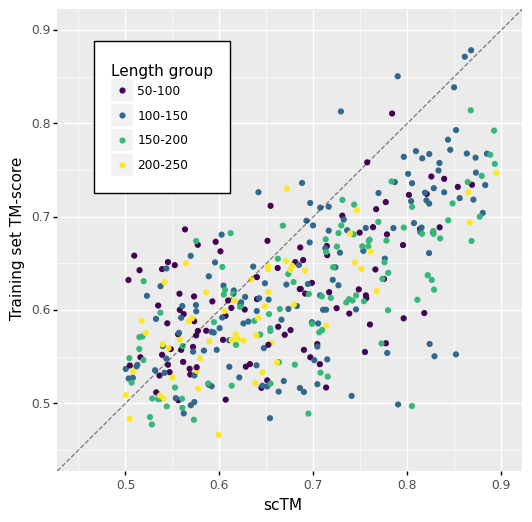

In [18]:
# Plot
p = (
    gg.ggplot(
        aligned_df,
        gg.aes('tm_score', 'top_hit_score', color='length_group')
    )
    + gg.geom_point()
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Training set TM-score')
    + gg.labels.labs(color='Length group')
    + gg.scales.ylim(0.45, 0.90)
    + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        figure_size=(6, 6),
        legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black')
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
)

print(p)

In [20]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'unconditional_training_set_comparison.png')
p.save(filename=fig_path, dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results/figures/unconditional_training_set_comparison.png
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


In [21]:
# Look at the most novel folds.
# aligned_df.sort_values('tm_score', ascending=False).sort_values('top_hit_score', ascending=True).head(20)
aligned_df.sort_values('top_hit_score', ascending=True).head(20)

,length,sample_id,Post-ProteinMPNN,tm_score,sample_path,header,sequence,of_path,length_group,designable,top_hit,top_hit_score
383,234,7,True,0.599163,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_234/sample_9/mpnn/esmf/sample_6.pdb,"T=0.1, sample=6, score=1.1060, global_score=1.1060, seq_recovery=0.1325",PPGVGPPVPCPGCGIGLGAPPAPGVCYGLPEFFTGPCGATDTVAGGAAGGDAVLAVARAHAPDPGGWKLGRRPVWTLDAGGLLRGLFREHLGAPEALAELRRALEAVRRERAEEWPPLTEEELLRELLVVVVRGEITEPARRAVEALAEAAGLPPEEALAAVREVVEGGSGVTGRPPWADWEIVYLKPPPGPGGPPDPPAGELLGLRGRGPDGEGLGVAVVSRDGGPGTAVLLE,None,200-250,True,6s8b_K,0.46644
280,166,8,True,0.528121,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_166/sample_0/mpnn/esmf/sample_4.pdb,"T=0.1, sample=4, score=1.0961, global_score=1.0961, seq_recovery=0.1265",GARWVEHPHGFKLFVLVPGAGPAGGVIFVRLGEPDPEEKVGLVKGGGVPLTDEGAEAILGERFGKAAAPELEKALKGGLVLIPGPDVPPEVLGAVGPGEPTPFARALRKAADGTPVTAEELLAPNPLDPEGQKLYAGGGKLIDKVYFIGGSPELAAEILAAAGAEP,None,150-200,True,5g5g_C,0.47741
255,156,8,True,0.572834,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_156/sample_7/mpnn/esmf/sample_6.pdb,"T=0.1, sample=6, score=1.2523, global_score=1.2523, seq_recovery=0.1410",MEEEKKEEEEKKLEECAKYLSSDRTVGVGTPTPGGGKCGQFGATAGGAAVPGAGAAGAGFTCTVCGPDGYAICECVPGGGTGPAAAGAGGEKCGVKIKYYKGIKDPEKTYVLIYKSKEIGVELKLEVKGKNGGEAFKKAIEEAKKLAEELKKLGKK,None,150-200,True,6fv5_B,0.48240
348,204,2,True,0.504523,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_204/sample_4/mpnn/esmf/sample_7.pdb,"T=0.1, sample=7, score=1.1445, global_score=1.1445, seq_recovery=0.1569",AVVVRNLEATKRQVAARRPGGCPECGPNTGFAFLPPGGAGAGVTLPPAPPVGSGGCGTATYYLLIDGKYTVKITIMVCDATDPDKDPEELLDEKAPPYYRAVGDPELGPGAAPLPECPPGEGPEARAKAEEIAKKIGGLTACGGHITAITVGVWEGGYLAGLAPGSGNLGTPEDAGGGFVGPNGTPGGLTGVAGSGDFKVPEAP,None,200-250,True,6ft6_4,0.48335
225,146,1,True,0.653795,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_146/sample_6/mpnn/esmf/sample_10.pdb,"T=0.1, sample=10, score=1.1557, global_score=1.1557, seq_recovery=0.1164",ADPDGTVTVTCTPAGTSWAALAATCGVSSSSAPGSGGVTLTGTVKYVSPDNTEITFGAGTGAVTAACGATACTTLSIGDGSCGFPLSPEVAGPVDPAALRALAEASGCTPAGVDAFAAWLGKFGPDGDGDWAALGGKPIGFSFSST,None,100-150,True,4bjr_B,0.48410
282,168,3,True,0.526080,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_168/sample_3/mpnn/esmf/sample_3.pdb,"T=0.1, sample=3, score=1.0078, global_score=1.0078, seq_recovery=0.1488",AALTGTGDAAALAAGGAAAATGTPAGPCGLTVEAAGLTLTVAGAGAVTPEVSLERGREVIEARTPEEARTAAPPPPLPGEGLGAGGVAGGVTGEHPGLTFPLGLTFELDPDPGPDPGPVGVETVGEGTVTVTGVTGGTAATATCTLVARVVTVGPGEAVGVAGIALAG,None,150-200,True,5k8g_A,0.48527
239,150,3,True,0.694757,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_150/sample_0/mpnn/esmf/sample_2.pdb,"T=0.1, sample=2, score=1.0974, global_score=1.0974, seq_recovery=0.1267",KPDFDKYKDAPLVKITIAKQCDASTPDSVATGVATPSGTNTCGGVKSTPGGCGVCGTGTGGAGTGPAVVFELTGTPENPGSKLTVYLVKDGAAYAAAGTPAATDAALETAEKLECEGGTEKSPGGTPEAQAAKQQKALDDCNAKLAEKLK,None,150-200,True,6ulg_N,0.48905
219,140,9,True,0.562006,"samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/length_140/sample_1/mpnn/of/T=0.1, sample=8, score=1.1663, global_score=1.1663, seq_recovery=0.1143.pdb",,None,"samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/length_140/sample_1/mpnn/of/T=0.1, sample=8, score=1.1663, global_score=1.1663, seq_recovery=0.1143.pdb",100-150,True,4j8f_A,0.48921
316,184,8,True,0.560563,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_184/sample_7/mpnn/esmf/sample_8.pdb,"T=0.1, sample=8, score=1.2184, global_score=1.2184, seq_recovery=0.1467",GTLDLSQKGVLTPGLTPELAEKLKDPEALGALPPELRALLLAAGAAAGADAPAALAALAAWAKELERFAPYEVVPLGGDPDTGVVIGPSPFGKGVLVAGDGKLTLYCDLEKGKKNPGCKPTCPLGAPLPALGRDLLGRVAALAALAYALPALPGELAEAPPTAEEAPEVLYKELAEKCCNGGPG,None,150-200,True,1urj_B,0.49513
253,156,2,True,0.543938,samples/sweep_2/24D_10M_2022Y_16h_25m_04s/hallucination/0/length_156/sample_5/mpnn/esmf/sample_3.pdb,"T=0.1, sample=3, score=1.2810, global_score=1.2810, seq_recovery=0.1603",LPGPLGLRITPDEVLGIVV